In [139]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

In [140]:
file_path = r"D:\Git Repositories\AuctionScout-AI-powered-player-recommendations-for-IPL-auctions\dataset\batsman_df.csv"
df = pd.read_csv(file_path)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   batsman             295 non-null    object 
 1   runs_batsman        295 non-null    int64  
 2   ball                295 non-null    int64  
 3   wickets_lost_count  295 non-null    int64  
 4   wickets_taken       295 non-null    int64  
 5   Batting_SR          295 non-null    float64
 6   Batting_Average     295 non-null    float64
 7   Recommendation      34 non-null     object 
dtypes: float64(2), int64(4), object(2)
memory usage: 18.6+ KB


In [142]:
df['Recommendation'] = df['Recommendation'].replace({"BUY" : 1, "MAYBE" : 2, "DON'T BUY" : 3, np.nan : -1})
df['Recommendation'] = df['Recommendation'].astype(int)
df_1 = df.sort_values(by=["Recommendation"], ascending=False)

C:\Users\edwin victor\AppData\Local\Temp\ipykernel_3868\1275241433.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Recommendation'] = df['Recommendation'].replace({"BUY" : 1, "MAYBE" : 2, "DON'T BUY" : 3, np.nan : -1})


In [143]:
labeled = df[df["Recommendation"] != -1]
unlabeled = df[df["Recommendation"] == -1]


In [144]:
x_labeled = labeled.iloc[:,1:7]
x_unlabeled = unlabeled.iloc[:,1:7]

In [145]:
corr_matrix = x_labeled.corr()

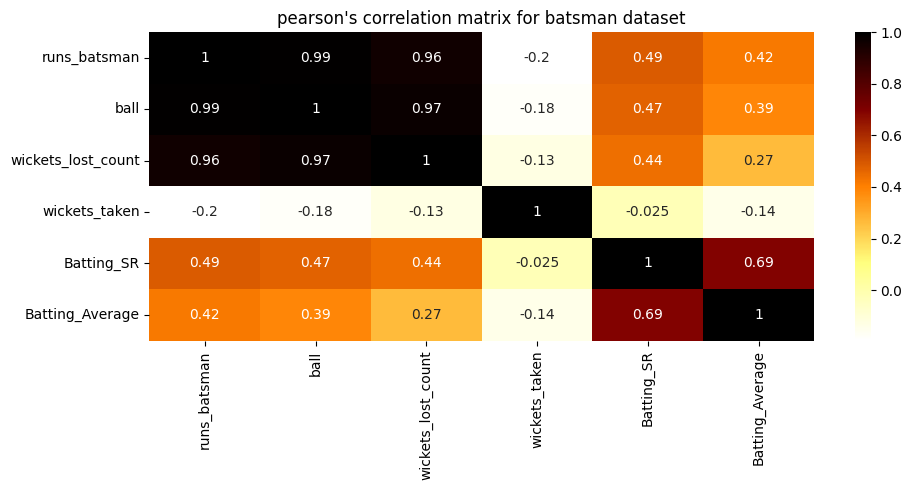

In [146]:
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap = plt.cm.afmhot_r)
plt.title("pearson's correlation matrix for batsman dataset")
plt.tight_layout()
plt.show()

In [147]:
def correlated_columns(dataset, threshold, corr_matrix):
    correlated_column = set()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold):
                col_name = corr_matrix.columns[i]
                correlated_column.add(col_name)
    return correlated_column

In [148]:
correlated_column = correlated_columns(x_labeled, 0.7,  corr_matrix)
correlated_column

{'ball', 'wickets_lost_count'}

In [149]:
x_labeled_columns_dropped = x_labeled.drop(columns=["ball", "wickets_lost_count"], axis=1)
x_unlabeled_columns_dropped = x_unlabeled.drop(columns=["ball", "wickets_lost_count"], axis=1)

In [150]:
x_labeled_columns_dropped.columns

Index(['runs_batsman', 'wickets_taken', 'Batting_SR', 'Batting_Average'], dtype='object')

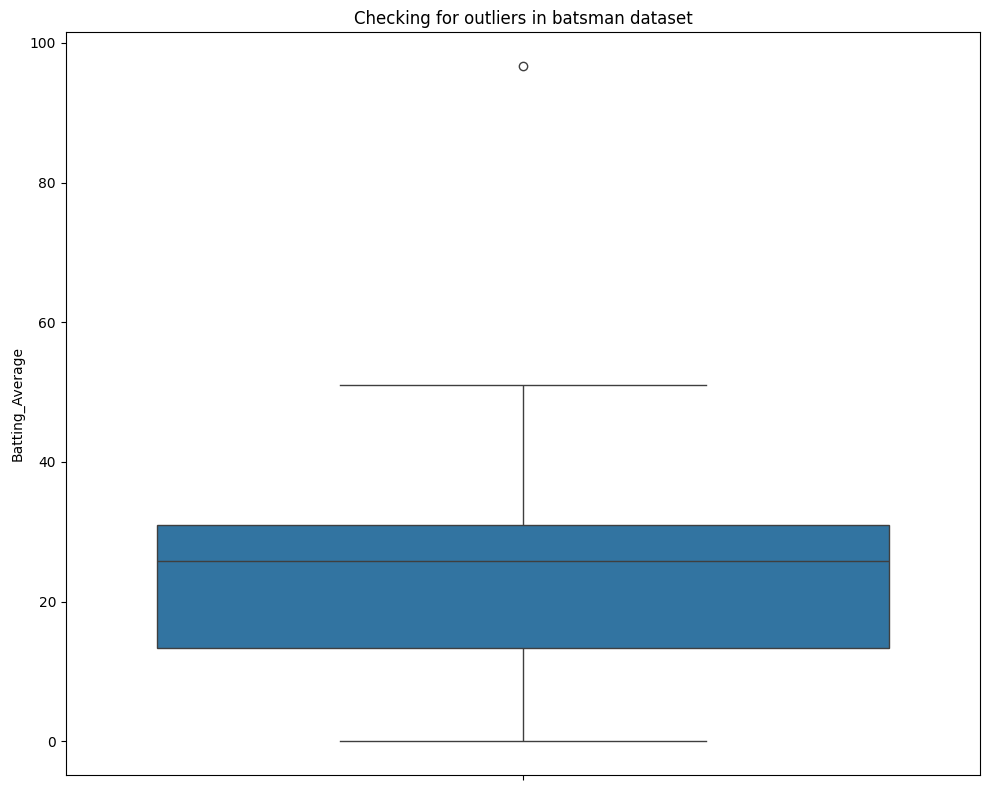

In [151]:
plt.figure(figsize=(10,8))
sns.boxplot(y = x_labeled_columns_dropped['Batting_Average'])
plt.title("Checking for outliers in batsman dataset")
plt.tight_layout()
plt.show()

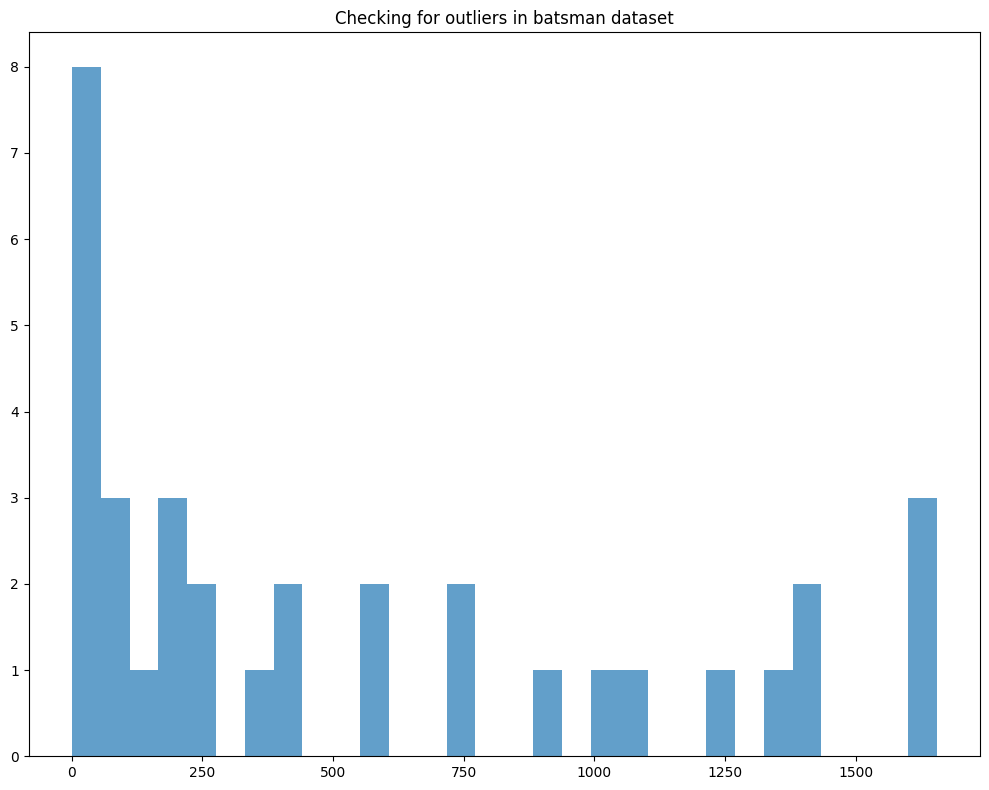

In [152]:
plt.figure(figsize=(10,8))
plt.hist(x_labeled_columns_dropped['runs_batsman'], bins = 30, alpha=0.7)
plt.title("Checking for outliers in batsman dataset")
plt.tight_layout()
plt.show()

In [153]:
def min_max_scaler(data):
    scaler = MinMaxScaler()
    scaled_feature_mm = scaler.fit_transform(data)
    scaled_feature_mm = pd.DataFrame(scaled_feature_mm, columns=data.columns, index=data.index)
    return scaled_feature_mm

In [154]:
def robust_scaler(data):
    scaler = RobustScaler()
    scaled_feature_rs = scaler.fit_transform(data)
    scaled_feature_rs = pd.DataFrame(scaled_feature_rs, columns=data.columns, index=data.index)
    return scaled_feature_rs

In [155]:
x_labeled_columns_dropped.head(5)

,runs_batsman,wickets_taken,Batting_SR,Batting_Average
0,73,0,91.25,12.17
1,55,63,82.09,7.86
2,249,36,121.46,13.11
3,1429,0,145.37,31.07
4,184,7,128.67,30.67


In [156]:
scaled_feature_mm_1 = min_max_scaler(x_labeled_columns_dropped[['runs_batsman']])
scaled_feature_rs_2 = robust_scaler(x_labeled_columns_dropped[['wickets_taken']])
scaled_feature_rs_3 = robust_scaler(x_labeled_columns_dropped[['Batting_SR']])
scaled_feature_mm_4 = min_max_scaler(x_labeled_columns_dropped[['Batting_Average']])

In [157]:
labeled_df_scaled = pd.concat([scaled_feature_mm_1, scaled_feature_rs_2, scaled_feature_rs_3, scaled_feature_mm_4], axis=1)
labeled_df_scaled.head()

,runs_batsman,wickets_taken,Batting_SR,Batting_Average
0,0.044109,0.000000,-1.979378,0.125892
1,0.033233,14.823529,-2.551789,0.081308
2,0.150453,8.470588,-0.091548,0.135616
3,0.863444,0.000000,1.402593,0.321403
4,0.111178,1.647059,0.359006,0.317265


In [158]:
x_labeled_target = labeled['Recommendation']
x_labeled_target.head()

0    3
1    3
2    3
3    1
4    1
Name: Recommendation, dtype: int64

In [159]:
y_unlabeled_target = unlabeled['Recommendation']
y_unlabeled_target.head()

13   -1
14   -1
16   -1
17   -1
18   -1
Name: Recommendation, dtype: int64

In [160]:
y_unlabeled = unlabeled[["runs_batsman", "wickets_taken", "Batting_SR", "Batting_Average"]]
scaled_feature_unlabeled_1 = min_max_scaler(y_unlabeled[["runs_batsman"]])
scaled_feature_unlabeled_2 = robust_scaler(y_unlabeled[["wickets_taken"]])
scaled_feature_unlabeled_3 = robust_scaler(y_unlabeled[["Batting_SR"]])
scaled_feature_unlabeled_4 = min_max_scaler(y_unlabeled[["Batting_Average"]])

In [161]:
unlabeled_df_scaled = pd.concat([scaled_feature_unlabeled_1, scaled_feature_unlabeled_2, scaled_feature_unlabeled_3, scaled_feature_unlabeled_4], axis=1)
unlabeled_df_scaled.head()

,runs_batsman,wickets_taken,Batting_SR,Batting_Average
13,0.082153,6.615385,0.249644,0.119892
14,0.652691,1.615385,0.334442,0.309677
16,0.000567,0.000000,-1.481473,0.010753
17,0.044759,-0.230769,0.458432,0.106237
18,0.040227,1.538462,-0.224941,0.190860


In [162]:
X_ALL = np.vstack((labeled_df_scaled, unlabeled_df_scaled))
X_ALL

array([[ 4.41087613e-02,  0.00000000e+00, -1.97937822e+00,
         1.25892211e-01],
       [ 3.32326284e-02,  1.48235294e+01, -2.55178878e+00,
         8.13075411e-02],
       [ 1.50453172e-01,  8.47058824e+00, -9.15481956e-02,
         1.35616013e-01],
       ...,
       [ 4.53257790e-03,  7.69230769e-01, -5.57719715e-01,
         4.30107527e-02],
       [ 2.83286119e-03,  1.15384615e+00, -2.04394299e+00,
         1.34408602e-02],
       [ 3.96600567e-03,  3.84615385e-01,  1.48764846e+00,
         7.52688172e-02]], shape=(295, 4))

In [163]:
y_all = np.concatenate((x_labeled_target, y_unlabeled_target))
y_all

array([ 3,  3,  3,  1,  1,  3,  3,  2,  2,  2,  3,  3,  1,  2,  3,  1,  1,
        1,  1,  2,  2,  2,  2,  1,  3,  3,  1,  1,  1,  3,  3,  3,  2,  2,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [164]:
label_propagation = LabelPropagation(kernel='rbf')
model_1 = label_propagation.fit(X_ALL, y_all)
predicted_labels_using_model_1 = model_1.predict(unlabeled_df_scaled)
predicted_labels_using_model_1

D:\miniconda\miniconda\envs\bbl\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
D:\miniconda\miniconda\envs\bbl\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LabelPropagation was fitted without feature names
  warnings.warn(


array([3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 1, 1, 3, 3, 2, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 2, 3, 3,
       3, 1, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 1, 3, 2, 3, 3, 2, 2, 3,
       3, 2, 3, 2, 3, 3, 3, 1, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2, 3, 1, 3,
       2, 1, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 1, 3, 3, 1, 1, 2, 2, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 1, 3, 3, 3, 3,
       1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 2, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2])

In [165]:
label_spreading = LabelSpreading(kernel='knn', alpha=0.8, n_neighbors=5)
model_2 = label_spreading.fit(X_ALL, y_all)
predicted_labels_using_model_2 = model_2.predict(unlabeled_df_scaled)
predicted_labels_using_model_2

D:\miniconda\miniconda\envs\bbl\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
D:\miniconda\miniconda\envs\bbl\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  warnings.warn(
D:\miniconda\miniconda\envs\bbl\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


array([3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1,
       3, 1, 3, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 3, 1,
       3, 1, 3, 1, 3, 1, 2, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 3, 2, 3, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3,
       3, 3, 2, 1, 3, 1, 3, 1, 1, 1, 2, 3, 1, 3, 1, 1, 2, 1, 1, 2, 2, 3,
       3, 2, 3, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 3, 3, 2, 1, 3, 3, 1, 3,
       1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 2, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 3, 3, 3, 1, 2, 2, 3, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 3, 1,
       3, 1, 1, 1, 3, 3, 3, 1, 2, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1,
       1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 1, 1, 1, 3, 3, 3, 1,
       3, 1, 1, 2, 3, 1, 1, 1, 3, 3, 3, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 3, 3, 1, 1, 2, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 2])

In [166]:
df.loc[df['Recommendation'] ==-1, "Recommendation"]= predicted_labels_using_model_2

In [169]:
df.iloc[0:10]

,batsman,runs_batsman,ball,wickets_lost_count,wickets_taken,Batting_SR,Batting_Average,Recommendation
0,A Lyth,73,80,6,0,91.25,12.17,3
1,A Zampa,55,67,7,63,82.09,7.86,3
2,AC Agar,249,205,19,36,121.46,13.11,3
3,AD Hales,1429,983,46,0,145.37,31.07,1
4,AD Russell,184,143,6,7,128.67,30.67,1
5,ADS Fletcher,206,160,10,0,128.75,20.60,3
6,AF Milne,13,15,3,8,86.67,4.33,3
7,AI Ross,1039,808,38,0,128.59,27.34,2
8,AJ Finch,1059,908,38,0,116.63,27.87,2
9,AJ Hose,402,322,17,0,124.84,23.65,2


In [170]:
df["Recommendation"] = df["Recommendation"].replace({1 : "BUY", 2 : "MAYBE", 3 : "DON'T BUY"})

In [172]:
file_path = r"D:\Git Repositories\AuctionScout-AI-powered-player-recommendations-for-IPL-auctions\dataset\batsman_df_labeled.csv"
df.to_csv(file_path, encoding='utf-8', index=False)